### Importando librerias necesarias

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,TimeSeriesSplit
import matplotlib.pyplot as plt
from Crossvalidation import MultipleTimeSeriesCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,RocCurveDisplay,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from Backtesting import backtest_1day_hold,backtest_1day_hold_train_test,backtest_1day_hold_train_test_market,backtest_1day_hold_open
from Crossvalidation import MultipleTimeSeriesCV,plot_time_series_split,walk_forward_validation
import warnings
warnings.filterwarnings("ignore")

### Entrenamiento de Modelos

In [2]:
# Cargamos los datos originales
df = pd.read_csv('../spyconalfas.csv')

<AxesSubplot:>

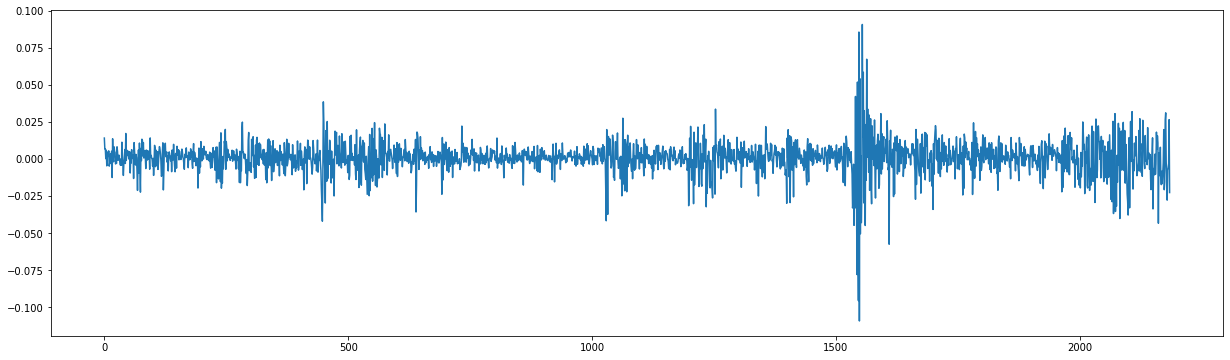

In [3]:
# Visualizamos los retornos
df['next returns'].plot(y='Date',figsize=(21,6))

In [4]:
# Separamos en X - (conjunto de entrenamiento) y Y - (etiquetas de los movimientos)
Y = df['next movement']
X = df
X.drop(['next movement','alpha53'],axis=1,inplace=True)

Tras haber separado las etquetas de los datos y haber eliminado Date y Alpha53, procedemos a separar en Train/Test:

In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,shuffle=False)
print('Intervalo de entrenamiento:',X_train['Date'].iloc[0],'-',X_train['Date'].iloc[-1])
print('Intervalo de prueba:',X_test['Date'].iloc[0],'-',X_test['Date'].iloc[-1])

Intervalo de entrenamiento: 2013-10-15 - 2021-01-06
Intervalo de prueba: 2021-01-07 - 2022-10-13


Ahora tomamos los retornos, los necesitaremos para calcular el rendimiento de nuestro algoritmo:

In [6]:
X_train_ret = X_train['next returns']
X_test_ret = X_test['next returns']
X_train.drop(['next returns','Date'],axis=1,inplace=True)
X_test.drop(['next returns','Date'],axis=1,inplace=True)

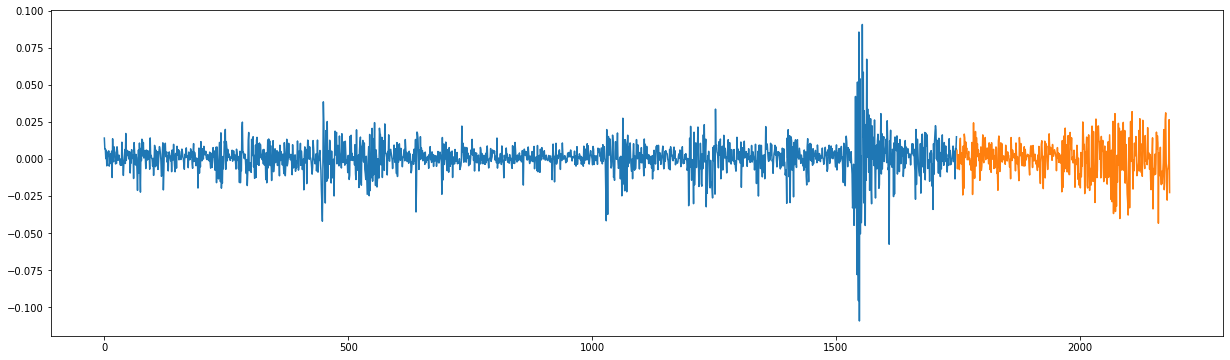

In [7]:
#Plotear Train/Test
plt.figure(figsize=(21,6))
plt.plot(X_train_ret)
plt.plot(X_test_ret)

Añadimos el preprocesado necesario:

In [8]:
X_train.describe()

,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,alpha10,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
count,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,...,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000
mean,226.318059,-0.000205,0.095224,0.228392,-0.653699,-0.248775,-0.554772,-0.496605,-0.138158,0.496278,...,-0.333725,0.000557,0.000582,0.000479,0.000472,0.000480,0.000518,0.000597,0.000581,0.000571
std,53.544227,0.276803,0.451406,0.384091,0.325972,0.135081,0.670345,0.274105,2.717071,0.274574,...,0.238254,0.010978,0.011021,0.011035,0.011045,0.011052,0.011056,0.011052,0.011028,0.011048
min,143.668335,-0.443642,-0.978837,-0.895961,-1.000000,-0.500199,-1.000000,-1.000000,-20.312088,0.000397,...,-0.994652,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424
25%,180.515022,-0.177497,-0.242479,-0.011643,-1.000000,-0.364030,-1.000000,-0.731115,-1.137115,0.262222,...,-0.503291,-0.003076,-0.003132,-0.003170,-0.003170,-0.003192,-0.003182,-0.003098,-0.003059,-0.003044
50%,220.392853,0.002006,0.115109,0.263202,-0.777778,-0.247407,-1.000000,-0.491607,-0.101288,0.495032,...,-0.290112,0.000597,0.000637,0.000552,0.000552,0.000588,0.000637,0.000637,0.000653,0.000643
75%,266.538589,0.302447,0.444271,0.539721,-0.333333,-0.134573,-0.166667,-0.262890,0.697960,0.729630,...,-0.132383,0.005182,0.005209,0.005142,0.005110,0.005161,0.005209,0.005325,0.005212,0.005227
max,364.738800,0.302447,0.972121,0.937606,-0.111111,-0.000199,1.000000,-0.002398,28.222427,1.000000,...,-0.000411,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603


In [9]:
cols_to_norm = ['Close','alpha54','alpha84']
scaler  = StandardScaler()

X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parametros:( accuracy ) Regresión Logística {'alpha': 0.01, 'eta0': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l1', 'shuffle': False}
Mejores parametros:( accuracy ) SVM {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Mejores parametros:( accuracy ) RandomForest {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 250, 'random_state': 42}
Mejores parametros:( accuracy ) XGBoost {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 10}
Win rate: (Regresión Logística) 0.5182648401826484
Win rate: (SVM) 0.5136986301369864
Win rate: (RandomForest) 0.5068493150684932
Win rate: (XGBoost) 0.5114155251141552


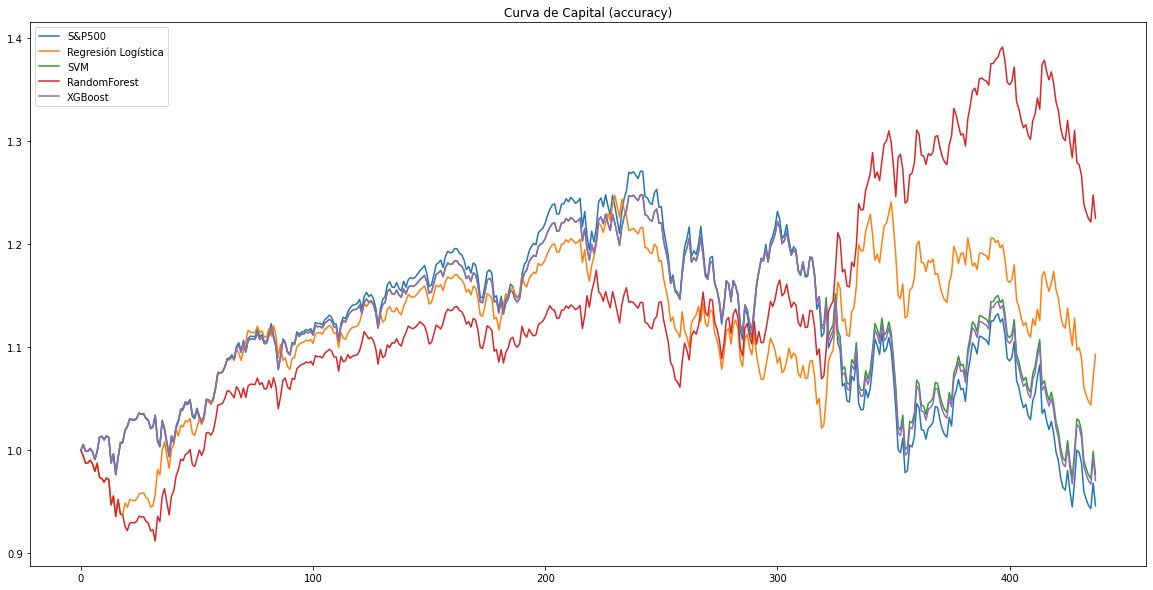

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parametros:( roc_auc ) Regresión Logística {'alpha': 0.001, 'eta0': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l2', 'shuffle': False}
Mejores parametros:( roc_auc ) SVM {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
Mejores parametros:( roc_auc ) RandomForest {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}
Mejores parametros:( roc_auc ) XGBoost {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 10}
Win rate: (Regresión Logística) 0.502283105022831
Win rate: (SVM) 0.5251141552511416
Win rate: (RandomForest) 0.4977168949771689
Win rate: (XGBoost) 0.5114155251141552


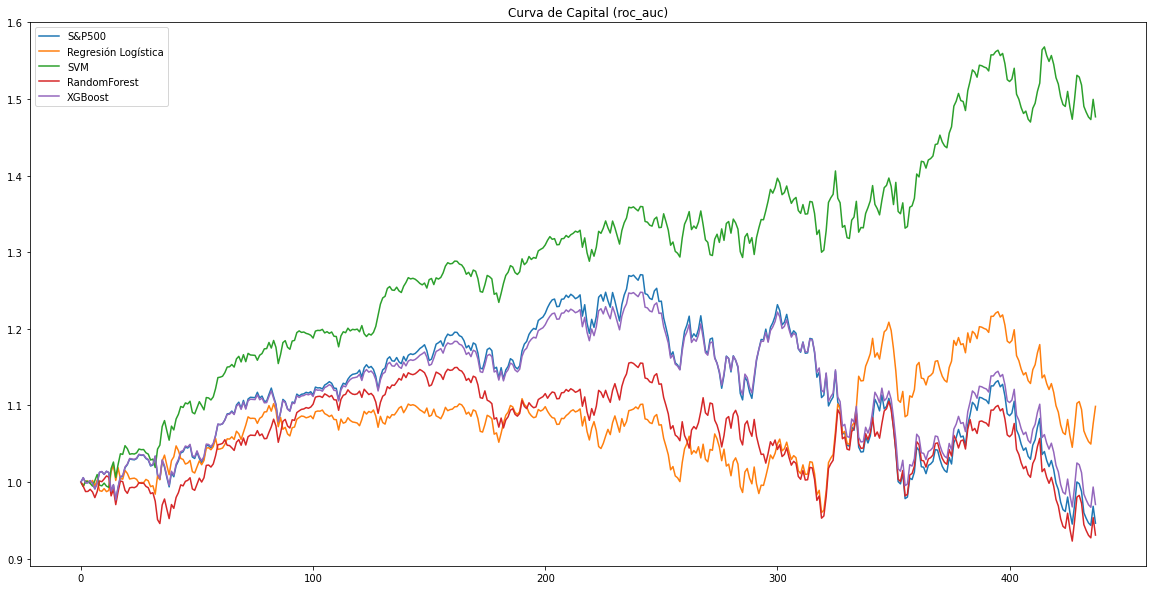

In [10]:
list_estimators = [SGDClassifier(),SVC(),RandomForestClassifier(),xgb.XGBClassifier()]
list_names = ['Regresión Logística','SVM','RandomForest','XGBoost']
metricas = ['accuracy','roc_auc']
primero=True


param_logreg = {
    'loss' : ['log'],
    'penalty' : ['l1','l2'],
    'eta0' : [0.01,0.1,0.5,1],
    'max_iter' :[1000,10000],
    'alpha' : [0.001,0.01],
    'shuffle': [False]
}

#Gamma para todos menos lineal, degree solo para poly, C todos
param_svm = {
    'C' : [0.1,1,10],
    'kernel': ['linear','rbf','poly','sigmoid'],
    'gamma' :[0.1,1,1000,10000]
}


param_rf = {
    'n_estimators':[100,150,200,250,300],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' : ['gini','entropy'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [3,4,5,6,7,8],
    'learning_rate' : [0.01,0.05,0.1],
    'n_estimators' : [100,150,200,250,300],
    'gamma' : [0,1,5,10],
    'reg_alpha' : [0.001,0.01],
    'random_state': [42]
}

list_params = [param_logreg,param_svm,param_rf,param_xgb]
cv = TimeSeriesSplit(5)

for metrica in metricas:
    primero = True
    list_estimators_entrenados = []
    for estimator,param in zip(list_estimators,list_params):
        if not isinstance(estimator,xgb.XGBClassifier):
            busqueda = GridSearchCV(estimator=estimator,param_grid=param,verbose=1,scoring=metrica,refit=True)
        else:
            busqueda = RandomizedSearchCV(estimator=estimator,param_distributions=param,verbose=1,scoring=metrica,refit=True)
        busqueda.fit(X_train,Y_train)
        list_estimators_entrenados.append(busqueda)

    for estimator,name in zip(list_estimators_entrenados,list_names):
        print('Mejores parametros:(',metrica,')',name,estimator.best_params_)
        Y_pred = estimator.predict(X_train)
        mat = ConfusionMatrixDisplay.from_predictions(Y_train,Y_pred)
        plt.grid(False)
        mat.figure_.savefig('{}_Confusion_Mat_{}_Train.jpg'.format(name,metrica))
        plt.close(mat.figure_)
        display = RocCurveDisplay.from_predictions(Y_train,Y_pred)
        display.figure_.savefig('{}_ROC_Curve_{}_Train.jpg'.format(name,metrica))
        plt.close(display.figure_)
        Y_pred = estimator.predict(X_test)
        mat = ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)
        plt.grid(False)
        mat.figure_.savefig('{}_Confusion_Mat_{}_Test.jpg'.format(name,metrica))
        plt.close(mat.figure_)
        display = RocCurveDisplay.from_predictions(Y_test,Y_pred)
        display.figure_.savefig('{}_ROC_Curve_{}_Test.jpg'.format(name,metrica))
        plt.close(display.figure_)

    plt.figure(figsize=(20,10))
    for estimator,name in zip(list_estimators_entrenados,list_names):
        Y_pred = estimator.predict(X_test)
        if primero:
            mercado=1
            primero=False
        else:
            mercado=0
        backtest_1day_hold(X_test_ret,Y_pred,show_market=mercado,label=name)
    plt.title('Curva de Capital ({})'.format(metrica))
    plt.legend()
    plt.show()

In [ ]:
###############################################################################
####################################PRUEBA#####################################
###############################################################################
list_estimators = [SGDClassifier(),SVC(),RandomForestClassifier(),xgb.XGBClassifier()]
list_names = ['Regresión Logística','SVM','RandomForest','XGBoost']
metricas = ['accuracy','roc_auc']
primero=True

#   Mejores parametros:( accuracy ) Regresión Logística {'alpha': 0.01, 'eta0': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l1', 'shuffle': False}
# Mejores parametros:( roc_auc ) Regresión Logística {'alpha': 0.001, 'eta0': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l2', 'shuffle': False}
param_logreg = {
    'loss' : ['log'],
    'penalty' : ['l1','l2'],
    'eta0' : [0.01],
    'max_iter' :[1000],
    'alpha' : [0.01,0.001],
    'shuffle': [False]
}

#Mejores parametros:( accuracy ) SVM {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
#Mejores parametros:( roc_auc ) SVM {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
param_svm = {
    'C' : [0.1,10],
    'kernel': ['linear','rbf'],
    'gamma' :[0.1]
}

# Mejores parametros:( accuracy ) RandomForest {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 250, 'random_state': 42}
#Mejores parametros:( roc_auc ) RandomForest {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}
param_rf = {
    'n_estimators':[100,250],
    'max_depth' : [4,7],
    'criterion' : ['gini'],
    'random_state': [42]
}

# Mejores parametros:( accuracy ) XGBoost {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 10}
# Mejores parametros:( roc_auc ) XGBoost {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 10}
param_xgb = {
    'max_depth' : [3],
    'learning_rate' : [0.01],
    'n_estimators' : [200,300],
    'gamma' : [10],
    'reg_alpha' : [0.01],
    'random_state': [42]
}

list_params = [param_logreg,param_svm,param_rf,param_xgb]
cv = TimeSeriesSplit(5)

for metrica in metricas:
    primero = True
    list_estimators_entrenados = []
    for estimator,param in zip(list_estimators,list_params):
        if not isinstance(estimator,xgb.XGBClassifier):
            busqueda = GridSearchCV(estimator=estimator,param_grid=param,verbose=1,scoring=metrica,refit=True)
        else:
            busqueda = RandomizedSearchCV(estimator=estimator,param_distributions=param,verbose=1,scoring=metrica,refit=True)
        busqueda.fit(X_train,Y_train)
        list_estimators_entrenados.append(busqueda)

    plt.figure(figsize=(20,10))
    for estimator,name in zip(list_estimators_entrenados,list_names):
        Y_pred = estimator.predict(X_test)
        if primero:
            mercado=1
            primero=False
        else:
            mercado=0
        backtest_1day_hold_open(X_test_ret,Y_pred,show_market=mercado,label=name)
    plt.title('Curva de Capital ({})'.format(metrica))
    plt.legend()
    plt.show()